# Transformer Network Application: Question Answering
This notebook, adapted from Deeplearning.ai's Deep Learning course, delves into another application of the previously built transformer architecture: Question Answering. Essentially, a Large Language Model (LLM) like GPT-4 is designed to handle question and answer (Q&A) tasks at its core.

**Objectives**:

* Perform extractive Question Answering 
* Fine-tune a pre-trained transformer model to a custom dataset
* Implement a QA model in TensorFlow and PyTorch

## Extractive Question Answering

Question answering (QA) is a natural language processing task focused on automatically providing answers to questions. In *extractive* QA, the objective is to pinpoint the exact segment of text that contains the answer. For example, given the text 'Jane visits Africa in September' and the question 'When will Jane go to Africa?', the model should identify 'September' as the answer.

* A variation of the Transformer model from the previous assignment will be utilized to address questions about textual data.
* Implementation of the extractive QA model will be carried out in both TensorFlow and PyTorch.

**Recommendation:**
* For further learning, explore [Course 4: Natural Language Processing with Attention Models](https://www.coursera.org/learn/attention-models-in-nlp/home/welcome) from the [Natural Language Processing Specialization](https://www.coursera.org/specializations/natural-language-processing?=) which includes building Transformers and performing QA using the [Trax](https://trax.readthedocs.io/en/latest/) library.

### Data Preprocessing

Execute the following cell to load the [QA bAbI dataset](https://research.fb.com/downloads/babi/), one of the bAbI datasets created by Facebook AI Research to advance the field of natural language processing.


In [1]:
from datasets import load_from_disk

# Load a dataset and print the first example in the training set
babi_dataset = load_from_disk('data/')
print(babi_dataset['train'][0])

{'story': {'answer': ['', '', 'office'], 'id': ['1', '2', '3'], 'supporting_ids': [[], [], ['1']], 'text': ['The office is north of the kitchen.', 'The garden is south of the kitchen.', 'What is north of the kitchen?'], 'type': [0, 0, 1]}}


Take a look at the format of the data. For a given story, there are two sentences which serve as the context, and one question. Each of these phrases has an ID. There is also a supporting fact ID which refers to a sentence in the story that helps answer the question. For example, for the question 'What is east of the hallway?', the supporting fact 'The bedroom is east of the hallway' has the ID '2'. There is also the answer, 'bedroom' for the question.

In [2]:
babi_dataset['train'][102]

{'story': {'answer': ['', '', 'bedroom'],
  'id': ['1', '2', '3'],
  'supporting_ids': [[], [], ['2']],
  'text': ['The bedroom is west of the office.',
   'The bedroom is east of the hallway.',
   'What is east of the hallway?'],
  'type': [0, 0, 1]}}

Check and see if the entire dataset of stories has this format.

In [3]:
type_set = set()
for story in babi_dataset['train']:
    if str(story['story']['type'] )not in type_set:
        type_set.add(str(story['story']['type'] ))

In [4]:
type_set

{'[0, 0, 1]'}

To make the data easier to work with, flatten the dataset to transform it from a dictionary structure to a table structure.

In [5]:
flattened_babi = babi_dataset.flatten()

In [6]:
flattened_babi

DatasetDict({
    train: Dataset({
        features: ['story.answer', 'story.id', 'story.supporting_ids', 'story.text', 'story.type'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['story.answer', 'story.id', 'story.supporting_ids', 'story.text', 'story.type'],
        num_rows: 1000
    })
})

In [7]:
next(iter(flattened_babi['train']))

{'story.answer': ['', '', 'office'],
 'story.id': ['1', '2', '3'],
 'story.supporting_ids': [[], [], ['1']],
 'story.text': ['The office is north of the kitchen.',
  'The garden is south of the kitchen.',
  'What is north of the kitchen?'],
 'story.type': [0, 0, 1]}

Accessing the required information has become significantly easier. Now, extracting the answer, question, and relevant facts from the story is straightforward, and facts can be consolidated into a single entry under 'sentences.'

In [8]:
def get_question_and_facts(story):
    dic = {}
    dic['question'] = story['story.text'][2]
    dic['sentences'] = ' '.join([story['story.text'][0], story['story.text'][1]])
    dic['answer'] = story['story.answer'][2]
    return dic

In [ ]:
processed = flattened_babi.map(get_question_and_facts)

In [10]:
processed['train'][2]

{'story.answer': ['', '', 'bedroom'],
 'story.id': ['1', '2', '3'],
 'story.supporting_ids': [[], [], ['2']],
 'story.text': ['The garden is north of the office.',
  'The bedroom is north of the garden.',
  'What is north of the garden?'],
 'story.type': [0, 0, 1],
 'question': 'What is north of the garden?',
 'sentences': 'The garden is north of the office. The bedroom is north of the garden.',
 'answer': 'bedroom'}

In [11]:
processed['test'][2]

{'story.answer': ['', '', 'bathroom'],
 'story.id': ['1', '2', '3'],
 'story.supporting_ids': [[], [], ['1']],
 'story.text': ['The bathroom is north of the garden.',
  'The hallway is north of the bathroom.',
  'What is north of the garden?'],
 'story.type': [0, 0, 1],
 'question': 'What is north of the garden?',
 'sentences': 'The bathroom is north of the garden. The hallway is north of the bathroom.',
 'answer': 'bathroom'}

The aim of extractive QA is to locate the segment of text that contains the answer to a given question. This involves identifying the start and end positions of the answer within the text. For instance, if the answer is 'September,' the task is to determine the start and end indices of 'September' within the context sentence 'Jane visits Africa in September.'

Utilize the following function to obtain the start and end indices of the answer in each story within the dataset.

In [12]:
def get_start_end_idx(story):
    str_idx = story['sentences'].find(story['answer'])
    end_idx = str_idx + len(story['answer'])
    return {'str_idx':str_idx,
          'end_idx': end_idx}

In [ ]:
processed = processed.map(get_start_end_idx)

In [14]:
num = 187
print(processed['test'][num])
start_idx = processed['test'][num]['str_idx']
end_idx = processed['test'][num]['end_idx']
print('answer:', processed['test'][num]['sentences'][start_idx:end_idx])

{'story.answer': ['', '', 'garden'], 'story.id': ['1', '2', '3'], 'story.supporting_ids': [[], [], ['2']], 'story.text': ['The hallway is south of the garden.', 'The garden is south of the bedroom.', 'What is south of the bedroom?'], 'story.type': [0, 0, 1], 'question': 'What is south of the bedroom?', 'sentences': 'The hallway is south of the garden. The garden is south of the bedroom.', 'answer': 'garden', 'str_idx': 28, 'end_idx': 34}
answer: garden


### Tokenize and Align with the Library

With the data prepared, the next step is to train a Transformer model for Question Answering. This involves a process similar to the one used in the Named-Entity Recognition lab: tokenizing and aligning the input. To prepare text data for a Transformer model, tokenize the input using a [Transformer tokenizer](https://huggingface.co/transformers/main_classes/tokenizer.html) that matches the type of Transformer model being used. For this exercise, the [DistilBERT fast tokenizer](https://huggingface.co/transformers/model_doc/distilbert.html) will be used, which standardizes sequence length to 512 and pads with zeros.

Transformer models often rely on tokenizers that break words into subwords. For example, the word 'Africa' might be split into multiple subtokens. This can lead to misalignment between the tags in the dataset and the labels generated by the tokenizer, as a single word may be divided into several tokens or special tokens may be added. To address this, it is crucial to align the start and end indices of the target answer word with the tokens generated by the tokenizer. This alignment can be achieved using a `tokenize_and_align()` function, which ensures that the indices of the sentence match the indices of the tokens for each word.

In [15]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('tokenizer/')

In [16]:
def tokenize_align(example):
    encoding = tokenizer(example['sentences'], example['question'], truncation=True, padding=True, max_length=tokenizer.model_max_length)
    start_positions = encoding.char_to_token(example['str_idx'])
    end_positions = encoding.char_to_token(example['end_idx']-1)
    if start_positions is None:
        start_positions = tokenizer.model_max_length
    if end_positions is None:
        end_positions = tokenizer.model_max_length
    return {'input_ids': encoding['input_ids'],
          'attention_mask': encoding['attention_mask'],
          'start_positions': start_positions,
          'end_positions': end_positions}

In [ ]:
qa_dataset = processed.map(tokenize_align)

In [18]:
qa_dataset = qa_dataset.remove_columns(['story.answer', 'story.id', 'story.supporting_ids', 'story.text', 'story.type'])

In [19]:
qa_dataset['train'][200]

{'question': 'What is north of the bathroom?',
 'sentences': 'The garden is north of the bathroom. The hallway is south of the bathroom.',
 'answer': 'garden',
 'str_idx': 4,
 'end_idx': 10,
 'input_ids': [101,
  1996,
  3871,
  2003,
  2167,
  1997,
  1996,
  5723,
  1012,
  1996,
  6797,
  2003,
  2148,
  1997,
  1996,
  5723,
  1012,
  102,
  2054,
  2003,
  2167,
  1997,
  1996,
  5723,
  1029,
  102],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 'start_positions': 2,
 'end_positions': 2}

#### Key Points
- The objective of *extractive* QA is to locate the section of the text that contains the answer to a given question.

- Transformer models typically use tokenizers that break words into subwords.
  - It is essential to align the start and end indices with the tokens corresponding to the target answer word before processing.

# Training

With the data tokenized and aligned, it is now ready to be fed into a pre-trained Transformer model. The DistilBERT model will be used, as it is compatible with the tokenizer employed for data preprocessing.

In [20]:
train_ds = qa_dataset['train']
test_ds = qa_dataset['test']

In [21]:
from transformers import TFDistilBertForQuestionAnswering
model = TFDistilBertForQuestionAnswering.from_pretrained("model/tensorflow", return_dict=False)

All model checkpoint layers were used when initializing TFDistilBertForQuestionAnswering.

All the layers of TFDistilBertForQuestionAnswering were initialized from the model checkpoint at model/tensorflow.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForQuestionAnswering for predictions without further training.


### TensorFlow and PyTorch Implementations

Both TensorFlow and PyTorch implementations are provided. To use the PyTorch implementation, change the model path to `"model/pytorch"`.

#### Train and Test Datasets

**Note:**
* In the TensorFlow implementation, data must be set to tensor format, which might result in ragged tensors (tensors of varying lengths).
* Convert ragged tensors to regular tensors using the `to_tensor()` method. This method pads the tensors and adjusts their dimensions to `[None, tokenizer.model_max_length]`, enabling the handling of variable-sized tensors in batches.

In [22]:
import tensorflow as tf

columns_to_return = ['input_ids','attention_mask', 'start_positions', 'end_positions']

train_ds.set_format(type='tf', columns=columns_to_return)

train_features = {x: train_ds[x] for x in ['input_ids', 'attention_mask']}
train_labels = {"start_positions": tf.reshape(train_ds['start_positions'], shape=[-1,1]),
                'end_positions': tf.reshape(train_ds['end_positions'], shape=[-1,1])}


train_tfdataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels)).batch(8)

#### Training

Training the model begins now!

* Develop a custom training function utilizing [tf.GradientTape()](https://www.tensorflow.org/api_docs/python/tf/GradientTape).
* Address two loss functions: one for the start index and one for the end index.
* `tf.GradientTape()` tracks operations during forward propagation to enable automatic differentiation during backpropagation.


In [23]:
EPOCHS = 3
loss_fn1 = tf.keras.losses.SparseCategoricalCrossentropy( from_logits=True)
loss_fn2 = tf.keras.losses.SparseCategoricalCrossentropy( from_logits=True)
opt = tf.keras.optimizers.Adam(learning_rate=3e-5)

losses = []
for epoch in range(EPOCHS):
    print("Starting epoch: %d"% epoch )
    for step, (x_batch_train, y_batch_train) in enumerate(train_tfdataset):
        with tf.GradientTape() as tape:
            answer_start_scores, answer_end_scores = model(x_batch_train)
            loss_start = loss_fn1(y_batch_train['start_positions'], answer_start_scores)
            loss_end = loss_fn2(y_batch_train['end_positions'], answer_end_scores)
            loss = 0.5 * (loss_start + loss_end)
        losses.append(loss)
        grads = tape.gradient(loss, model.trainable_weights)
        opt.apply_gradients(zip(grads, model.trainable_weights))

        if step % 20 == 0:
            print("Training loss (for one batch) at step %d: %.4f"% (step, 
                                                                   float(loss_start)))


Starting epoch: 0
Training loss (for one batch) at step 0: 3.3659
Training loss (for one batch) at step 20: 1.2487
Training loss (for one batch) at step 40: 0.5977
Training loss (for one batch) at step 60: 0.6212
Training loss (for one batch) at step 80: 0.5496
Training loss (for one batch) at step 100: 0.0529
Training loss (for one batch) at step 120: 0.5034
Starting epoch: 1
Training loss (for one batch) at step 0: 0.5608
Training loss (for one batch) at step 20: 0.1605
Training loss (for one batch) at step 40: 0.5075
Training loss (for one batch) at step 60: 0.3201
Training loss (for one batch) at step 80: 0.1203
Training loss (for one batch) at step 100: 0.0774
Training loss (for one batch) at step 120: 0.4645
Starting epoch: 2
Training loss (for one batch) at step 0: 0.3172
Training loss (for one batch) at step 20: 0.1097
Training loss (for one batch) at step 40: 0.5090
Training loss (for one batch) at step 60: 0.2719
Training loss (for one batch) at step 80: 0.1035
Training loss 

Take a look at the losses and try playing around with some of the hyperparameters for better results!

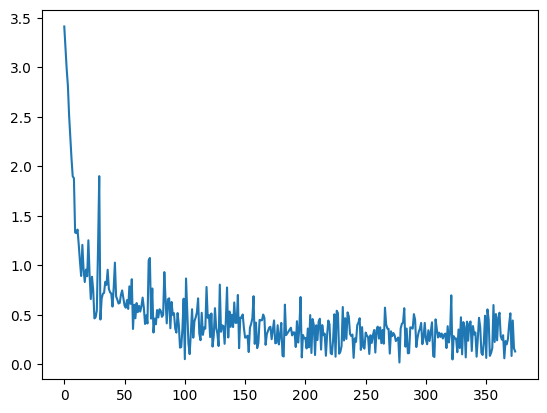

In [24]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.show()

The model has been successfully trained to automatically answer questions. Test it by asking a question about a story.

In [25]:
question, text = 'What is south of the bedroom?','The hallway is south of the garden. The garden is south of the bedroom.'
input_dict = tokenizer(text, question, return_tensors='tf')
outputs = model(input_dict)
start_logits = outputs[0]
end_logits = outputs[1]

all_tokens = tokenizer.convert_ids_to_tokens(input_dict["input_ids"].numpy()[0])
answer = ' '.join(all_tokens[tf.math.argmax(start_logits, 1)[0] : tf.math.argmax(end_logits, 1)[0]+1])
print(question, answer.capitalize())

What is south of the bedroom? Garden


## PyTorch implementation

[PyTorch](https://pytorch.org/) is an open source machine learning framework developed by Facebook's AI Research lab that can be used for computer vision and natural language processing. It is quite compatible with the bAbI dataset.

#### Train and test dataset

Go ahead and try creating a train and test dataset by importing PyTorch.

In [26]:
from torch.utils.data import DataLoader

columns_to_return = ['input_ids','attention_mask', 'start_positions', 'end_positions']
train_ds.set_format(type='pt', columns=columns_to_return)
test_ds.set_format(type='pt', columns=columns_to_return)

For the accuracy metrics in the PyTorch implementation, the F1 score will be used for start and end indices across the entire test dataset, serving as the loss functions. For reference, see the [F1 score documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html).

In [27]:
from sklearn.metrics import f1_score

def compute_metrics(pred):
    start_labels = pred.label_ids[0]
    start_preds = pred.predictions[0].argmax(-1)
    end_labels = pred.label_ids[1]
    end_preds = pred.predictions[1].argmax(-1)
    
    f1_start = f1_score(start_labels, start_preds, average='macro')
    f1_end = f1_score(end_labels, end_preds, average='macro')
    
    return {
        'f1_start': f1_start,
        'f1_end': f1_end,
    }

#### Training

Now it is time to load a pre-trained model. 

**Note:** You will be using the DistilBERT instead of TFDistilBERT for a PyTorch implementation.

In [28]:
del model # We delete the tensorflow model to avoid memory issues

In [29]:
from transformers import DistilBertForQuestionAnswering

pytorch_model = DistilBertForQuestionAnswering.from_pretrained("model/pytorch")

Instead of implementing a custom training loop, the [Trainer](https://huggingface.co/transformers/main_classes/trainer.html) will be utilized. This class provides a basic training loop and is straightforward to use in PyTorch.

In [30]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='results',          # output directory
    overwrite_output_dir=True,
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=8,   # batch size for evaluation
    warmup_steps=20,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir=None,            # directory for storing logs
    logging_steps=50
)

trainer = Trainer(
    model=pytorch_model,                 # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_ds,         # training dataset
    eval_dataset=test_ds,
    compute_metrics=compute_metrics             # evaluation dataset
)

trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForQuestionAnswering.forward` and have been ignored: end_idx, str_idx, question, sentences, answer. If end_idx, str_idx, question, sentences, answer are not expected by `DistilBertForQuestionAnswering.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 1000
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 375
  Number of trainable parameters = 66364418


Step,Training Loss
50,1.532300
100,0.750500
150,0.438300
200,0.430300
250,0.418900
300,0.291500
350,0.342800




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=375, training_loss=0.5782912762959799, metrics={'train_runtime': 11.1524, 'train_samples_per_second': 269.0, 'train_steps_per_second': 33.625, 'total_flos': 19904183208000.0, 'train_loss': 0.5782912762959799, 'epoch': 3.0})

In [ ]:
trainer.evaluate(test_ds)

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForQuestionAnswering.forward` and have been ignored: end_idx, str_idx, question, sentences, answer. If end_idx, str_idx, question, sentences, answer are not expected by `DistilBertForQuestionAnswering.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


Now let's ask our PyTorch model some question! 
* Before testing the model with a question, PyTorch can send the model and inputs to the GPU if the machine has one, or the CPU if it does not. 
* Proceed to tokenize the input and create PyTorch tensors and send them to the device. 
* The rest of the pipeline is relatively similar to the one implemented for TensorFlow.   


In [ ]:
import torch

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

pytorch_model.to(device)

question, text = 'What is east of the hallway?','The kitchen is east of the hallway. The garden is south of the bedroom.'

input_dict = tokenizer(text, question, return_tensors='pt')

input_ids = input_dict['input_ids'].to(device)
attention_mask = input_dict['attention_mask'].to(device)

outputs = pytorch_model(input_ids, attention_mask=attention_mask)

start_logits = outputs[0]
end_logits = outputs[1]

all_tokens = tokenizer.convert_ids_to_tokens(input_dict["input_ids"].numpy()[0])
answer = ' '.join(all_tokens[torch.argmax(start_logits, 1)[0] : torch.argmax(end_logits, 1)[0]+1])

print(question, answer.capitalize())

### Recap:
- Transformer models are typically trained with tokenizers that split words into subwords.
  - Aligning the start and end indices with the tokens associated with the target answer word is crucial before processing.
- PyTorch offers a lightweight and user-friendly framework, ideal for rapid prototyping, while TensorFlow excels in scalability and is widely used in production.
  - `tf.GradientTape` facilitates the creation of custom training loops in TensorFlow.
  - The `Trainer` API in PyTorch provides a straightforward training loop compatible with models and datasets.
